<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb"><< Index</a>
<br>
<a href="./1_5_SLSTR_radiance_BT_spectra.ipynb"><< SLSTR radiance and brightness temperature spectra</a>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2022 EUMETSAT <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h3>Learn SLSTR: Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook:
  - **<a href="./1_1a_SLSTR_data_access_Data_Store.ipynb" target="_blank">1_1a_SLSTR_data_access_Data_Store.ipynb</a>** (if using the Data Store)
    <br><br>**OR**<br><br>
  - **<a href="./1_1b_SLSTR_data_access_HDA.ipynb" target="_blank">1_1b_SLSTR_data_access_HDA.ipynb</a>** (if using WEkEO)
    
</div>
<hr>

# 1.6 Using SLSTR sea surface temperature products


### Data used

| Product Description | Data Store collection ID| Product Navigator | WEkEO HDA ID | WEkEO metadata |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|:-----------------:|
| Sentinel-3 SLSTR level-2 (NTC) | EO:EUM:DAT:0412 | <a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:SENTINEL-3:SL_2_SST?query=SLSTR&s=advanced" target="_blank">link</a> | EO:EUM:DAT:SENTINEL-3:SL_2_WST___ | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AEUM%3ADAT%3ASENTINEL-3%3ASL_2_WST___&initial=1" target="_blank">link</a> |

### Learning outcomes

At the end of this notebook you will know;
* A bit about using and defining functions in Python and Jupyter Notebooks.
* About the sea surface temperature (SST) products available from SLSTR.
* How to plot SST data on maps.
* How SST data is produced using multiple retrieval algorithms.
* The utility of error statistics.
* About quality levels and flags.
* How to apply information from error statistics, quality levels, and flags, to extract and visualise the highest quality data.


### Outline

One of the main objectives of the Sentinel-3 mission is the delivery of sea surface temperature measurements. The Sea and Land Surface Temperature Radiometer (SLSTR) measures the electromagnetic radiation emitted by the sea surface, at various wavelengths. This data can then be combined, using a variety of methods (known as 'retrieval algorithms') to convert the measurements in to the geophysical values of temperature. For the SST data to be useful, estimates of error, as well as indicators of quality, can help users decide how valid the data is for their particular application. This notebook explains how retrieval algorithms work, and how to apply the supporting quality information to SST data from SLSTR.


<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>

 0. [A quick preamble on functions](#section0)
 1. [SLSTR SST products](#section1)
 2. [Reading SLSTR SST data](#section2)
 3. [Plotting SST data](#section3)
 4. [Understanding retrieval algorithms](#section4)
 5. [Understanding single sensor error statistics](#section5)
 6. [Understanding quality levels and applying flags](#section6)
 7. [Bringing it all togethers](#section7)

<hr>

In [1]:
import cartopy
from cartopy.feature.nightshade import Nightshade
import datetime
import eumartools
import glob
import inspect
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import ListedColormap
import numpy as np
import os
import warnings
import xarray as xr

warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 12})

# define a discrete colourmap for later use
cmap = ListedColormap(['0.75', '#B03A2E', '#F39C12', '#F1C40F', '#5DADE2', '#1F618D'])

<div class="alert alert-warning" role="alert">

## <a id='section0'></a>0. A quick preamble on functions
[Back to top](#TOC_TOP)

</div>

In this notebook we will define a simple function `slstr_plot`, which can be called throughout the notebook. We do this, so that we can use the same piece of code multiple times without re-writing it.

In [2]:
# define a quick function to save us time throughout this notebook
def slstr_plot(m, band_vars, var, limits, lon="lon", lat="lat", cmap=plt.cm.RdBu_r):
    """Function to plot SLSTR data and embellish with gridlines and labels

    Args:
        m (axis):                   the axis to plot into
        band_vars (xarray Dataset): the variable containing the data
        limits (list):              min x, max x, min y, max y, vmin, vmax
        lon (str):                  the longitude variables in band_vars
        lat (str):                  the latitude variables in band_vars
        cmap (colormap):            the colormap to use in the plot

    Returns:
        if successful, returns p1, the pcolormesh plot instance.

    """
    minx, maxx, miny, maxy, vmin, vmax = limits
    p1 = m.pcolormesh(np.squeeze(band_vars[lon][miny:maxy,minx:maxx]),
                      np.squeeze(band_vars[lat][miny:maxy,minx:maxx]),
                      var,
                      transform=cartopy.crs.PlateCarree(central_longitude=0.0), 
                      cmap=cmap, zorder=1, vmin=vmin, vmax=vmax)

    # Embellish with gridlines
    g1 = m.gridlines(draw_labels = True, zorder=20, color='0.0', linestyle='--',linewidth=0.5)
    g1.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
    g1.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))
    g1.top_labels = False
    g1.right_labels = False
    g1.xlabel_style = {'color': 'black'}
    g1.ylabel_style = {'color': 'black'}
    m.set(facecolor = "1.0")
    m.axis('off')
    
    return p1

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. SLSTR sea-surface temperature products and algorithms
[Back to top](#TOC_TOP)

</div>

Measuring sea surface temperature requires a definition of what 'surface' actually means. In practice, the scientific community (particularly the <a href="https://www.ghrsst.org/" target="_blank"> Group for High Resolution SST (GHRSST)</a>) has defined several measurements of SST as shown in the Figure 1. This is important to consider because (as shown in figure 1), the temperature of the 'surface' can vary with depth, particularly when there are strong gradients between night and day. 

<img src='https://www.ghrsst.org/wp-content/uploads/2021/04/newerSSTdef.gif' align='centre' width='75%'></img>
<center>Figure 1: Sea surface temperature definitions (courtesy: GHRSST)</center>

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Reading SLSTR SST data
[Back to top](#TOC_TOP)

</div>

In [3]:
SAFE_directory = os.path.join(os.getcwd(), 'products',
    'S3A_SL_2_WST____20220209T213232_20220209T231332_20220211T074946_6059_081_385______MAR_O_NT_003.SEN3')

In [4]:
band_vars = xr.open_mfdataset(glob.glob(os.path.join(SAFE_directory,'*.nc')))
band_vars.close()

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Plotting SST data
[Back to top](#TOC_TOP)

</div>

In [5]:
# set some parameters
grid_reduce = 5
k_to_c = 273.15

t1 = datetime.datetime(2022, 2, 9, 21, 32, 32)
t2 = datetime.datetime(2022, 2, 9, 23, 13, 32)
delta = t2-t1
avg_date = t1 + delta/2

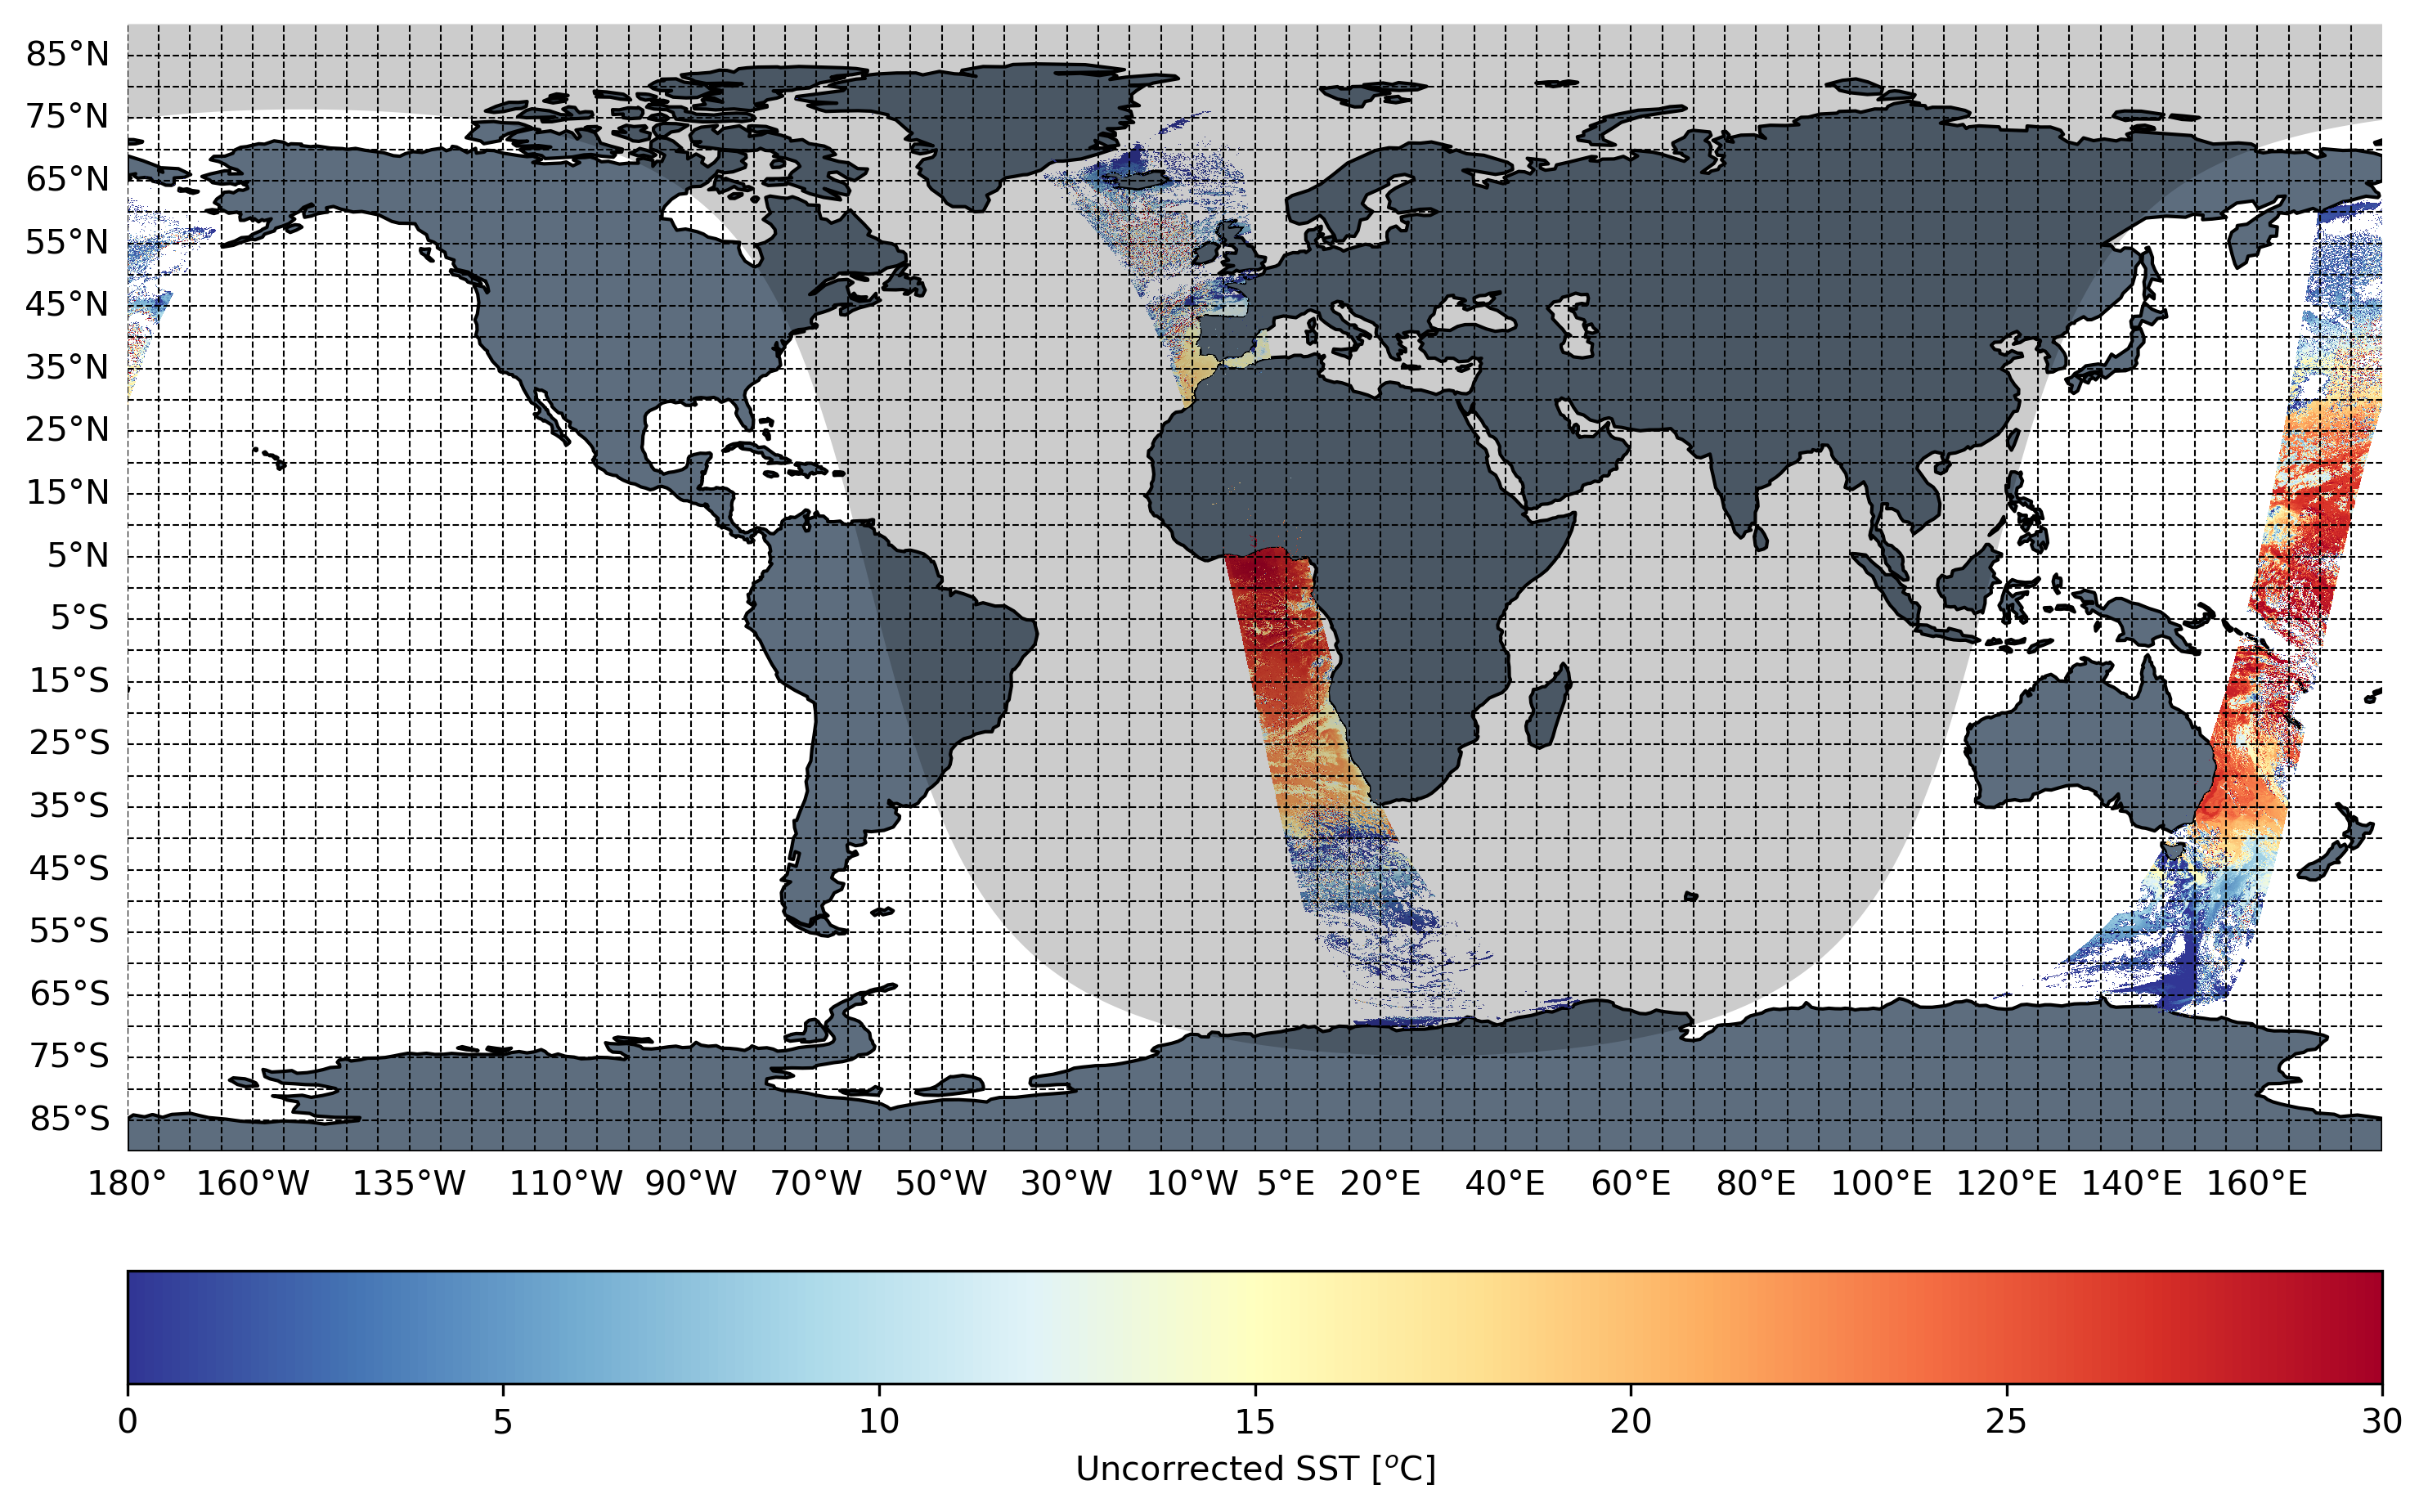

In [6]:
fig = plt.figure(figsize=(10, 10), dpi=300)
m = plt.subplot(projection=cartopy.crs.PlateCarree())
m.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='k', facecolor='#5D6D7E')
m.set_global()

# issues with +/- 180 unless you do this.
shift_lon = np.array(band_vars["lon"][::grid_reduce, ::grid_reduce])
ii = np.where(shift_lon < 0.0)
shift_lon[ii] = shift_lon[ii] + 360.0

p1 = m.pcolormesh(shift_lon, band_vars["lat"][::grid_reduce, ::grid_reduce],
                  band_vars["sea_surface_temperature"][0, ::grid_reduce, ::grid_reduce] - k_to_c,
                  transform=cartopy.crs.PlateCarree(central_longitude=0.0), 
                  cmap=plt.cm.RdYlBu_r, zorder=1, vmin=0, vmax=30)

# Embellish with gridlines
g1 = m.gridlines(draw_labels = True, zorder=20, color='0.0', linestyle='--',linewidth=0.5)
g1.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
g1.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))
g1.top_labels = False
g1.right_labels = False
g1.xlabel_style = {'color': 'black'}
g1.ylabel_style = {'color': 'black'}
m.set(facecolor = "1.0")
m.axis('off')
m.add_feature(Nightshade(avg_date, alpha=0.2))

cbar = fig.colorbar(p1, location='bottom', pad=0.05)
cbar.set_label('Uncorrected SST [$^{o}$C]')
plt.tight_layout()

In [7]:
# look at two smaller areas; Gulf of Cadiz (GoC) and East Australian Current (EAC)
coords = {}
coords["GoC"] = {}
coords["GoC"]["name"] = "Gulf of Cadiz"
coords["GoC"]["lons"] = [-10.0, 0.0,  0.0, -10.0, -10.0]
coords["GoC"]["lats"] = [30.0, 30.0, 40.0,  40.0,  30.0]

coords["EAC"] = {}
coords["EAC"]["name"] = "East Australian Current"
coords["EAC"]["lons"] = [150.0, 160.0, 160.0, 150.0, 150.0]
coords["EAC"]["lats"] = [-37.5, -37.5, -27.5, -27.5, -37.5]

In [8]:
# this takes a bit of time to run as SLSTR L2 products are so large! Could use grid_reduce again.
# ...better to update the routine with a "no mask" option - this is probably the issue.
for item in coords:
    coords[item]["x"], coords[item]["y"], mask = eumartools.subset_image(np.array(band_vars["lon"]),
                                                                         np.array(band_vars["lat"]),
                                                                         coords[item]["lons"],
                                                                         coords[item]["lats"])

Plotting Gulf of Cadiz
Plotting East Australian Current


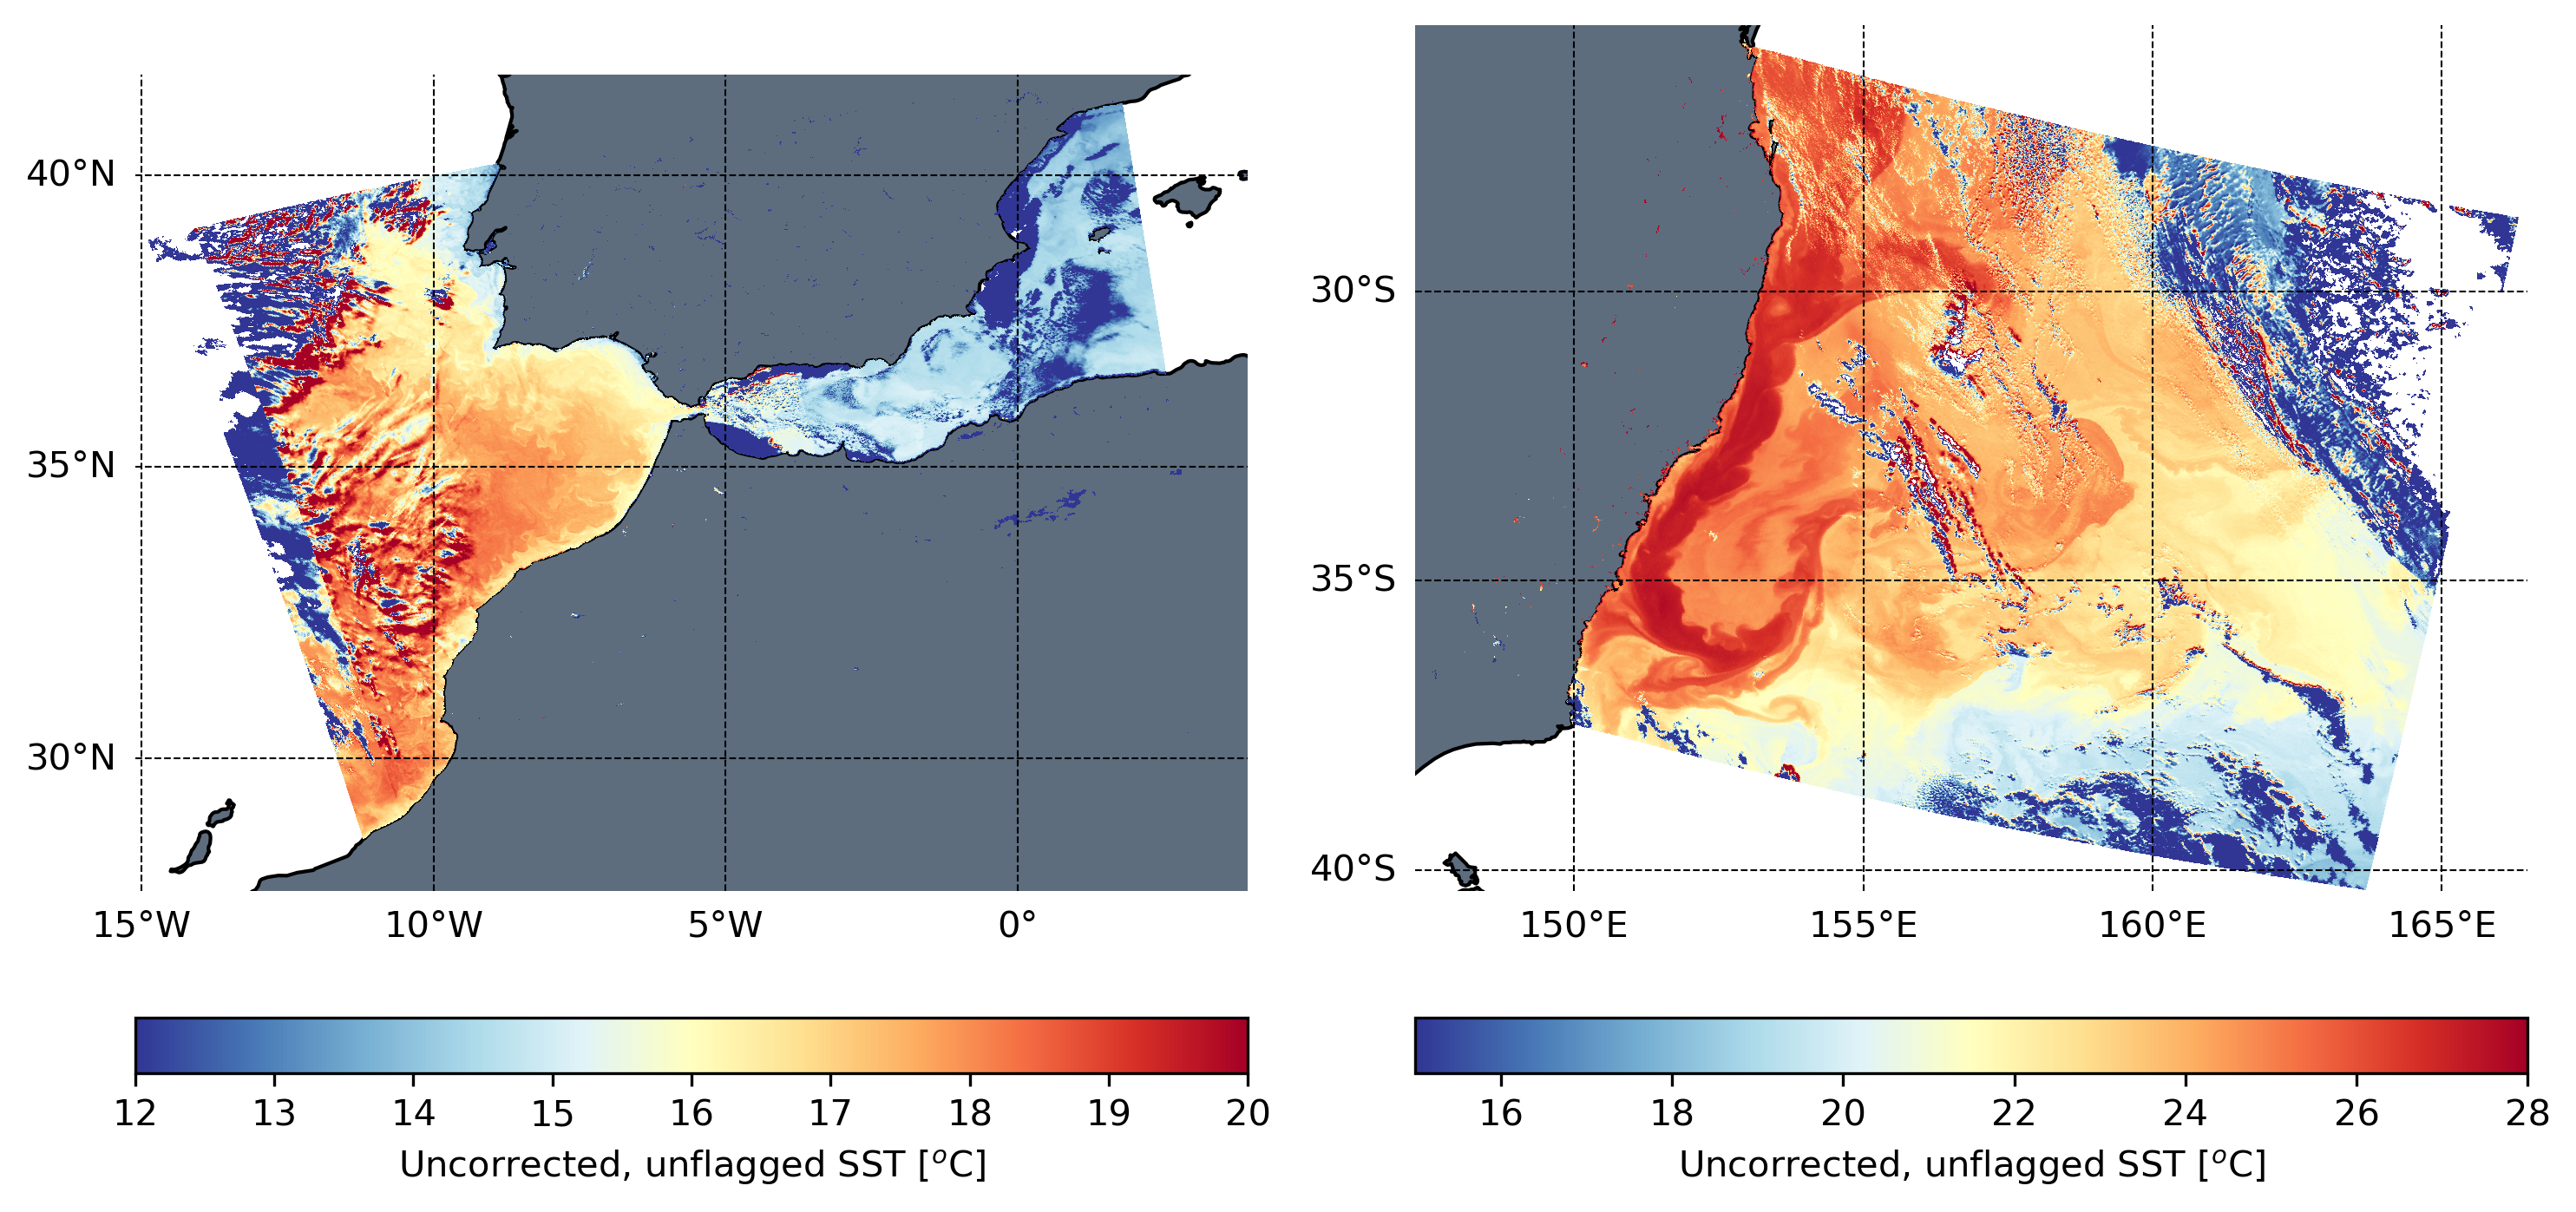

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10), dpi=300, subplot_kw={"projection": cartopy.crs.PlateCarree()})

for m, loc, vmin, vmax in zip(axs, coords, [12, 15], [20, 28]):
    print(f"Plotting {coords[loc]['name']}")
    
    # setting "x" to use full swath width
    minx = 0 ; maxx = np.shape(band_vars["lon"])[-1]
    miny = min(coords[loc]["y"]) ; maxy = max(coords[loc]["y"])
    
    m.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='k', facecolor='#5D6D7E')
    pvar = band_vars["sea_surface_temperature"][0, miny:maxy, minx:maxx] - k_to_c
    p1 = slstr_plot(m, band_vars, pvar, [minx, maxx, miny, maxy, vmin, vmax], cmap=plt.cm.RdYlBu_r)

    cbar = fig.colorbar(p1, ax=m, location='bottom', pad=0.05)
    cbar.set_label('Uncorrected, unflagged SST [$^{o}$C]')

plt.tight_layout()

<div class="alert alert-info" role="alert">

## <a id='section4'></a>4. Understanding retrieval algorithms
[Back to top](#TOC_TOP)

</div>

Plotting Gulf of Cadiz
Plotting East Australian Current


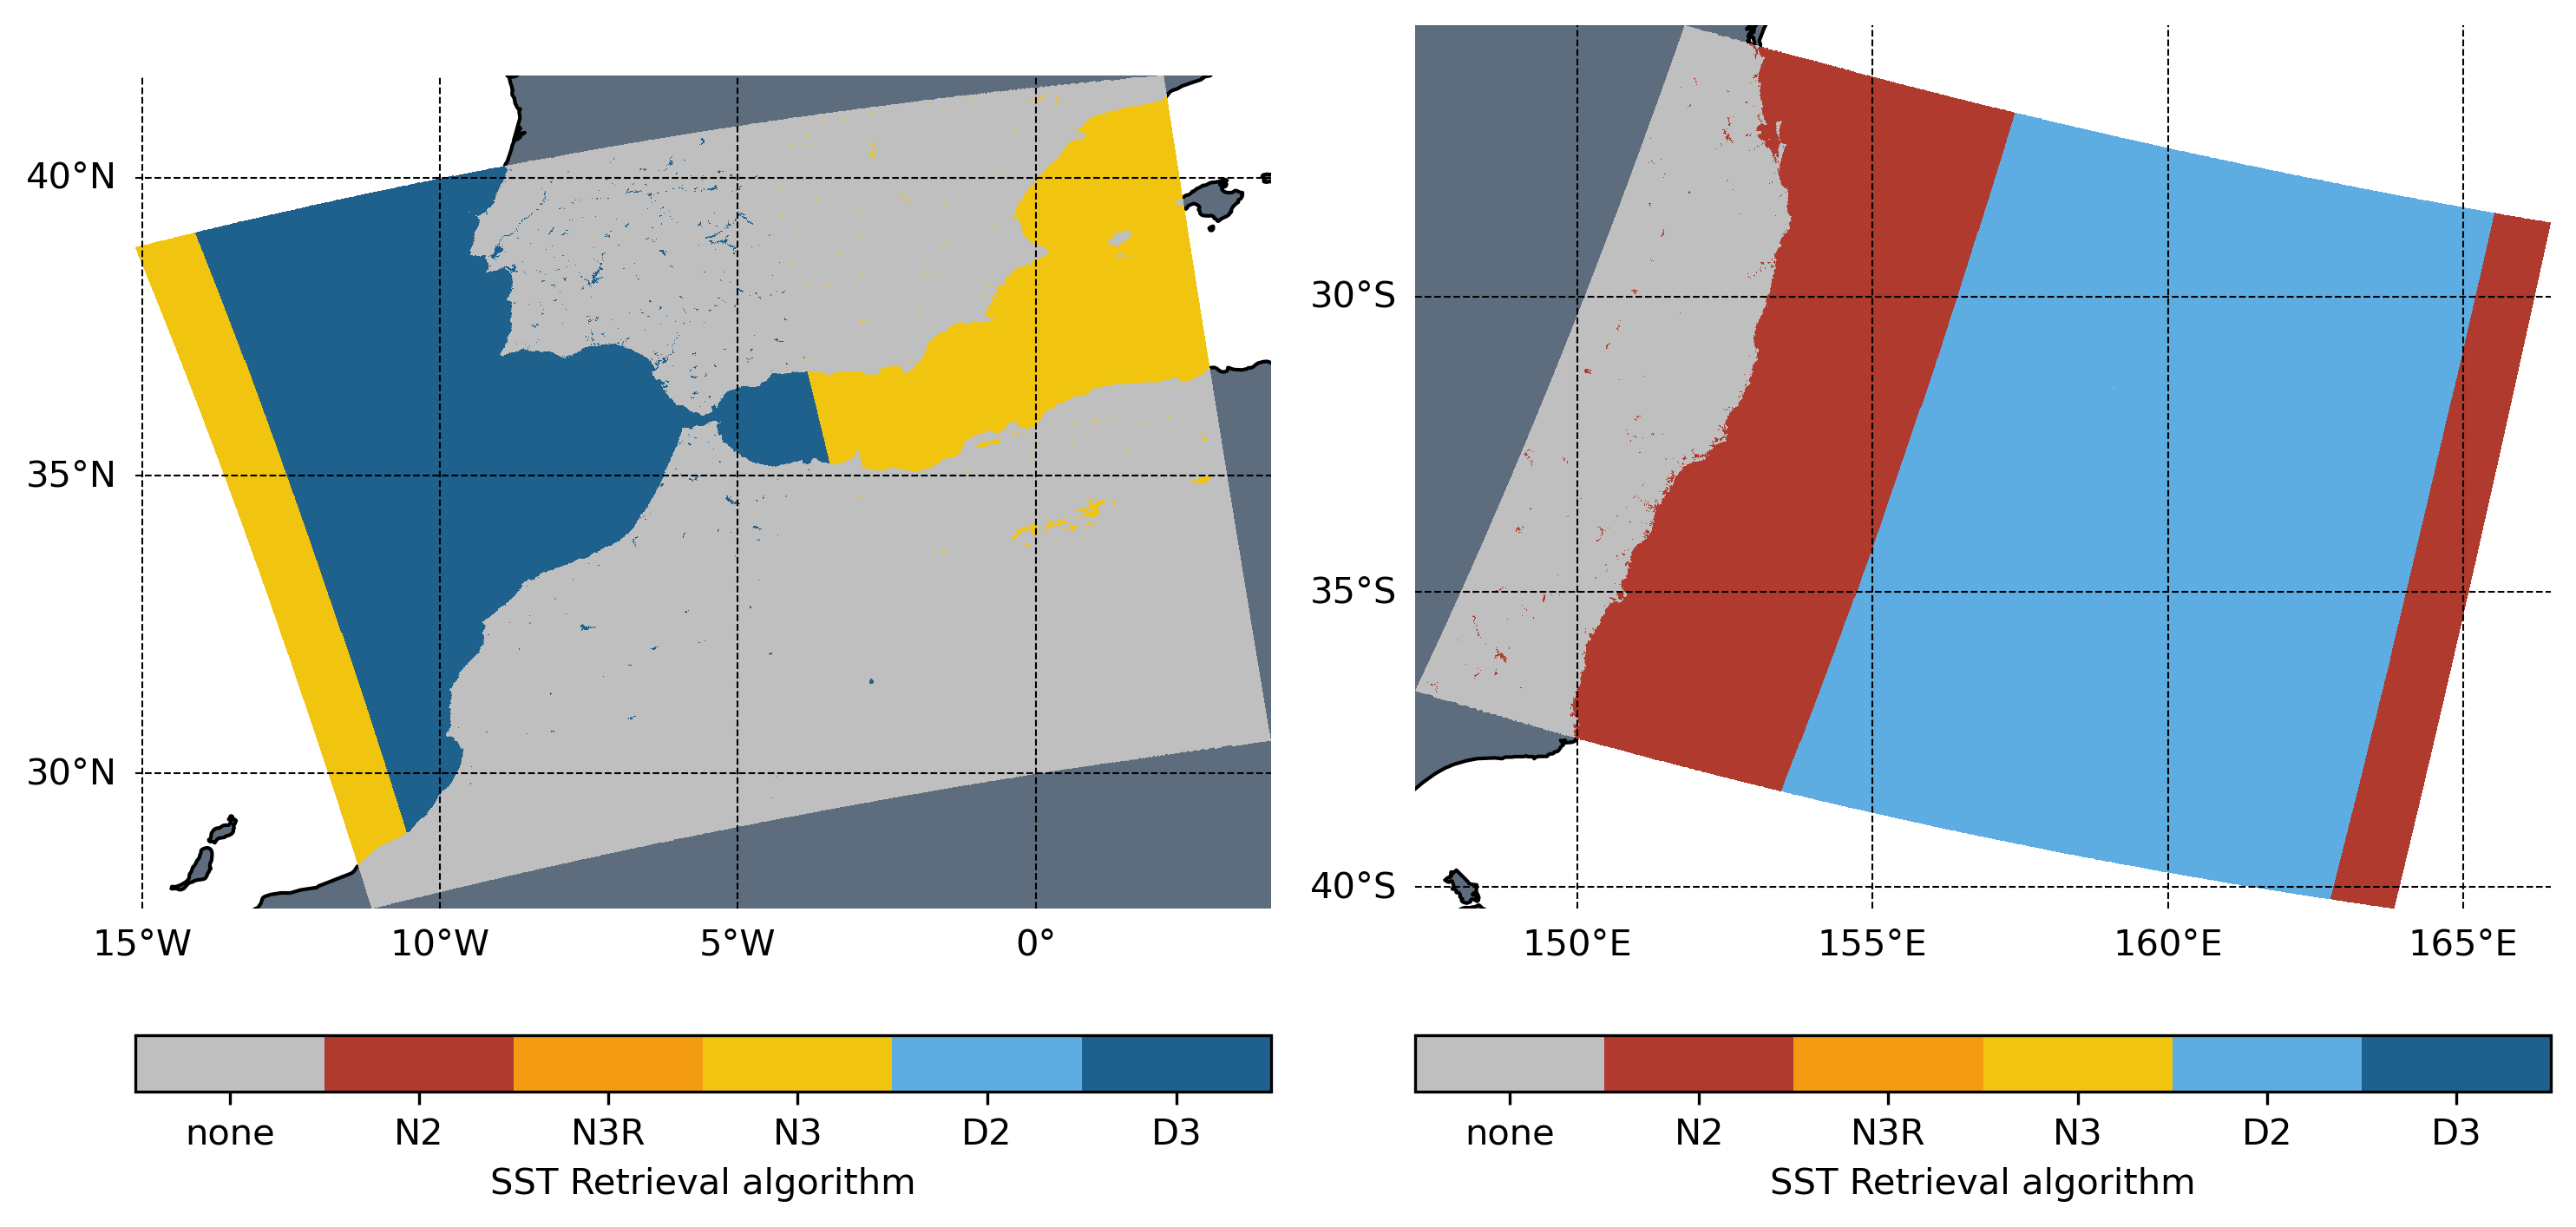

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10), dpi=300, subplot_kw={"projection": cartopy.crs.PlateCarree()})

for m, loc, vmin, vmax in zip(axs, coords , [0, 0], [6, 6]):
    print(f"Plotting {coords[loc]['name']}")

    # setting "x" to use full swath width
    minx = 0 ; maxx = np.shape(band_vars["lon"])[-1]
    miny = min(coords[loc]["y"]) ; maxy = max(coords[loc]["y"])
    
    m.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='k', facecolor='#5D6D7E')
    pvar = band_vars["sst_algorithm_type"][0, miny:maxy, minx:maxx]
    p1 = slstr_plot(m, band_vars, pvar, [minx, maxx, miny, maxy, vmin, vmax], cmap=cmap)

    cbar = fig.colorbar(p1, ax=m, location='bottom', pad=0.05)
    cbar.set_label('SST Retrieval algorithm')
    cbar.set_ticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
    cbar.set_ticklabels(['none', 'N2', 'N3R', 'N3', 'D2', 'D3'])
    
plt.tight_layout()

<div class="alert alert-info" role="alert">

## <a id='section5'></a>5. Understanding single sensor error statistics
[Back to top](#TOC_TOP)

</div>

Need to correct with the sses bias...

Plotting Gulf of Cadiz
Plotting East Australian Current


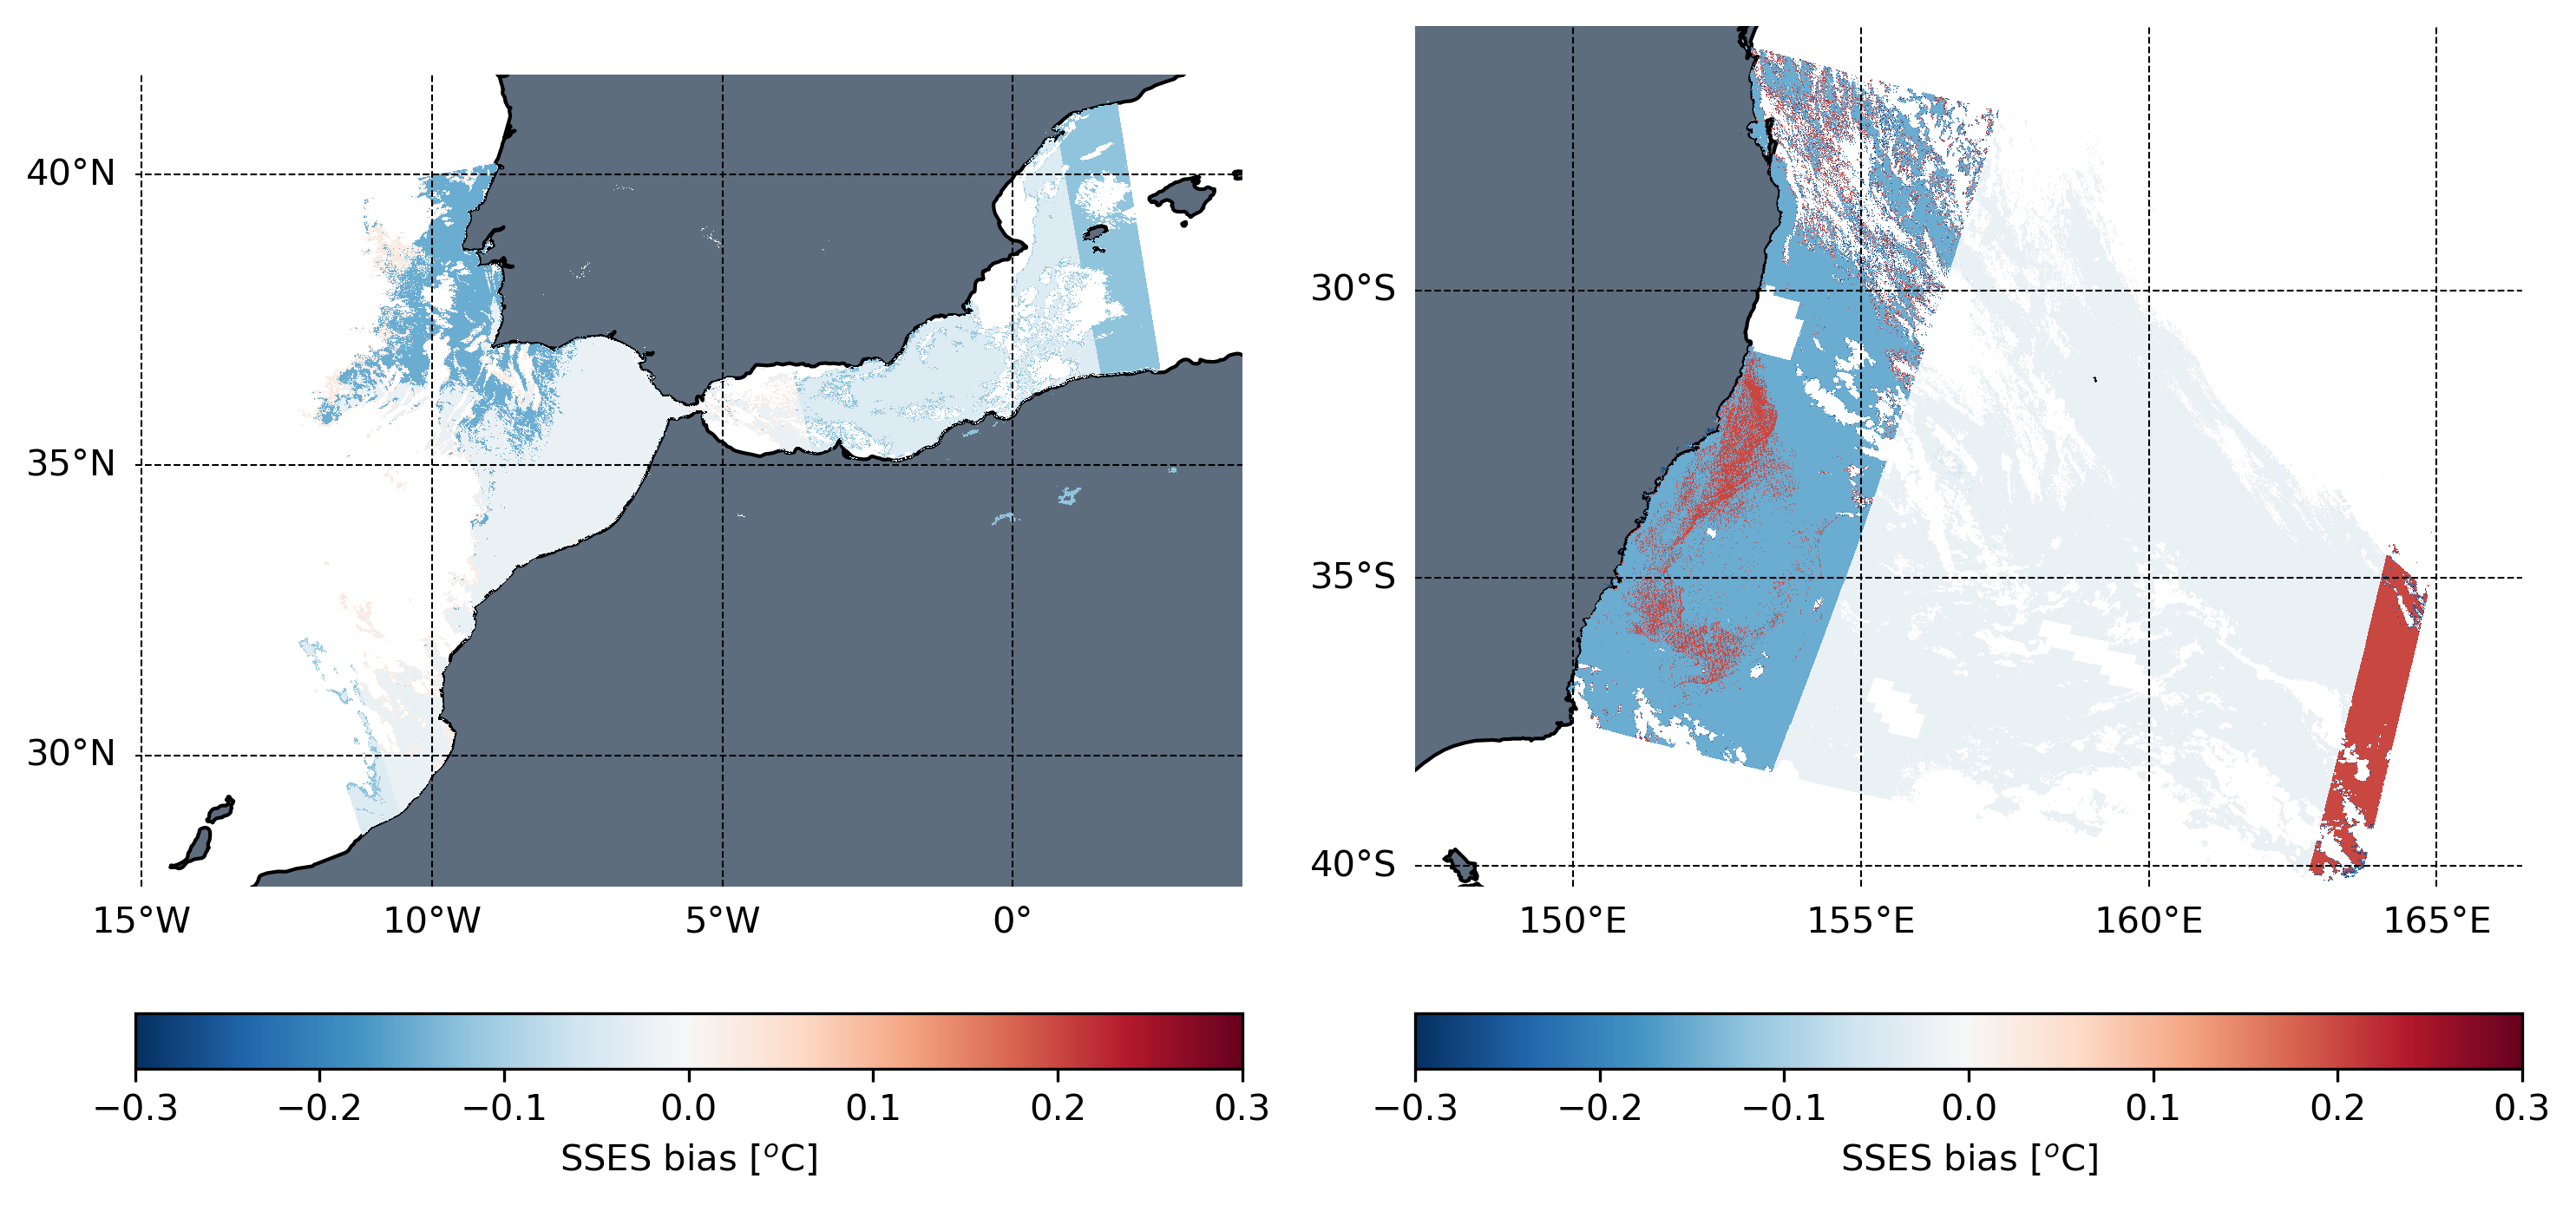

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10), dpi=300, subplot_kw={"projection": cartopy.crs.PlateCarree()})

for m, loc, vmin, vmax in zip(axs, coords , [-0.3, -0.3], [0.3, 0.3]):
    print(f"Plotting {coords[loc]['name']}")

    # setting "x" to use full swath width
    minx = 0 ; maxx = np.shape(band_vars["lon"])[-1]
    miny = min(coords[loc]["y"]) ; maxy = max(coords[loc]["y"])
    
    pvar = band_vars["sses_bias"][0, miny:maxy, minx:maxx]
    m.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='k', facecolor='#5D6D7E')
    p1 = slstr_plot(m, band_vars, pvar, [minx, maxx, miny, maxy, vmin, vmax], cmap=plt.cm.RdBu_r)
    
    cbar = fig.colorbar(p1, ax=m, location='bottom', pad=0.05)
    cbar.set_label('SSES bias [$^{o}$C]')

plt.tight_layout()

<div class="alert alert-info" role="alert">

## <a id='section6'></a>6. Understanding quality levels and applying flags
[Back to top](#TOC_TOP)

</div>

Plotting Gulf of Cadiz
Plotting East Australian Current


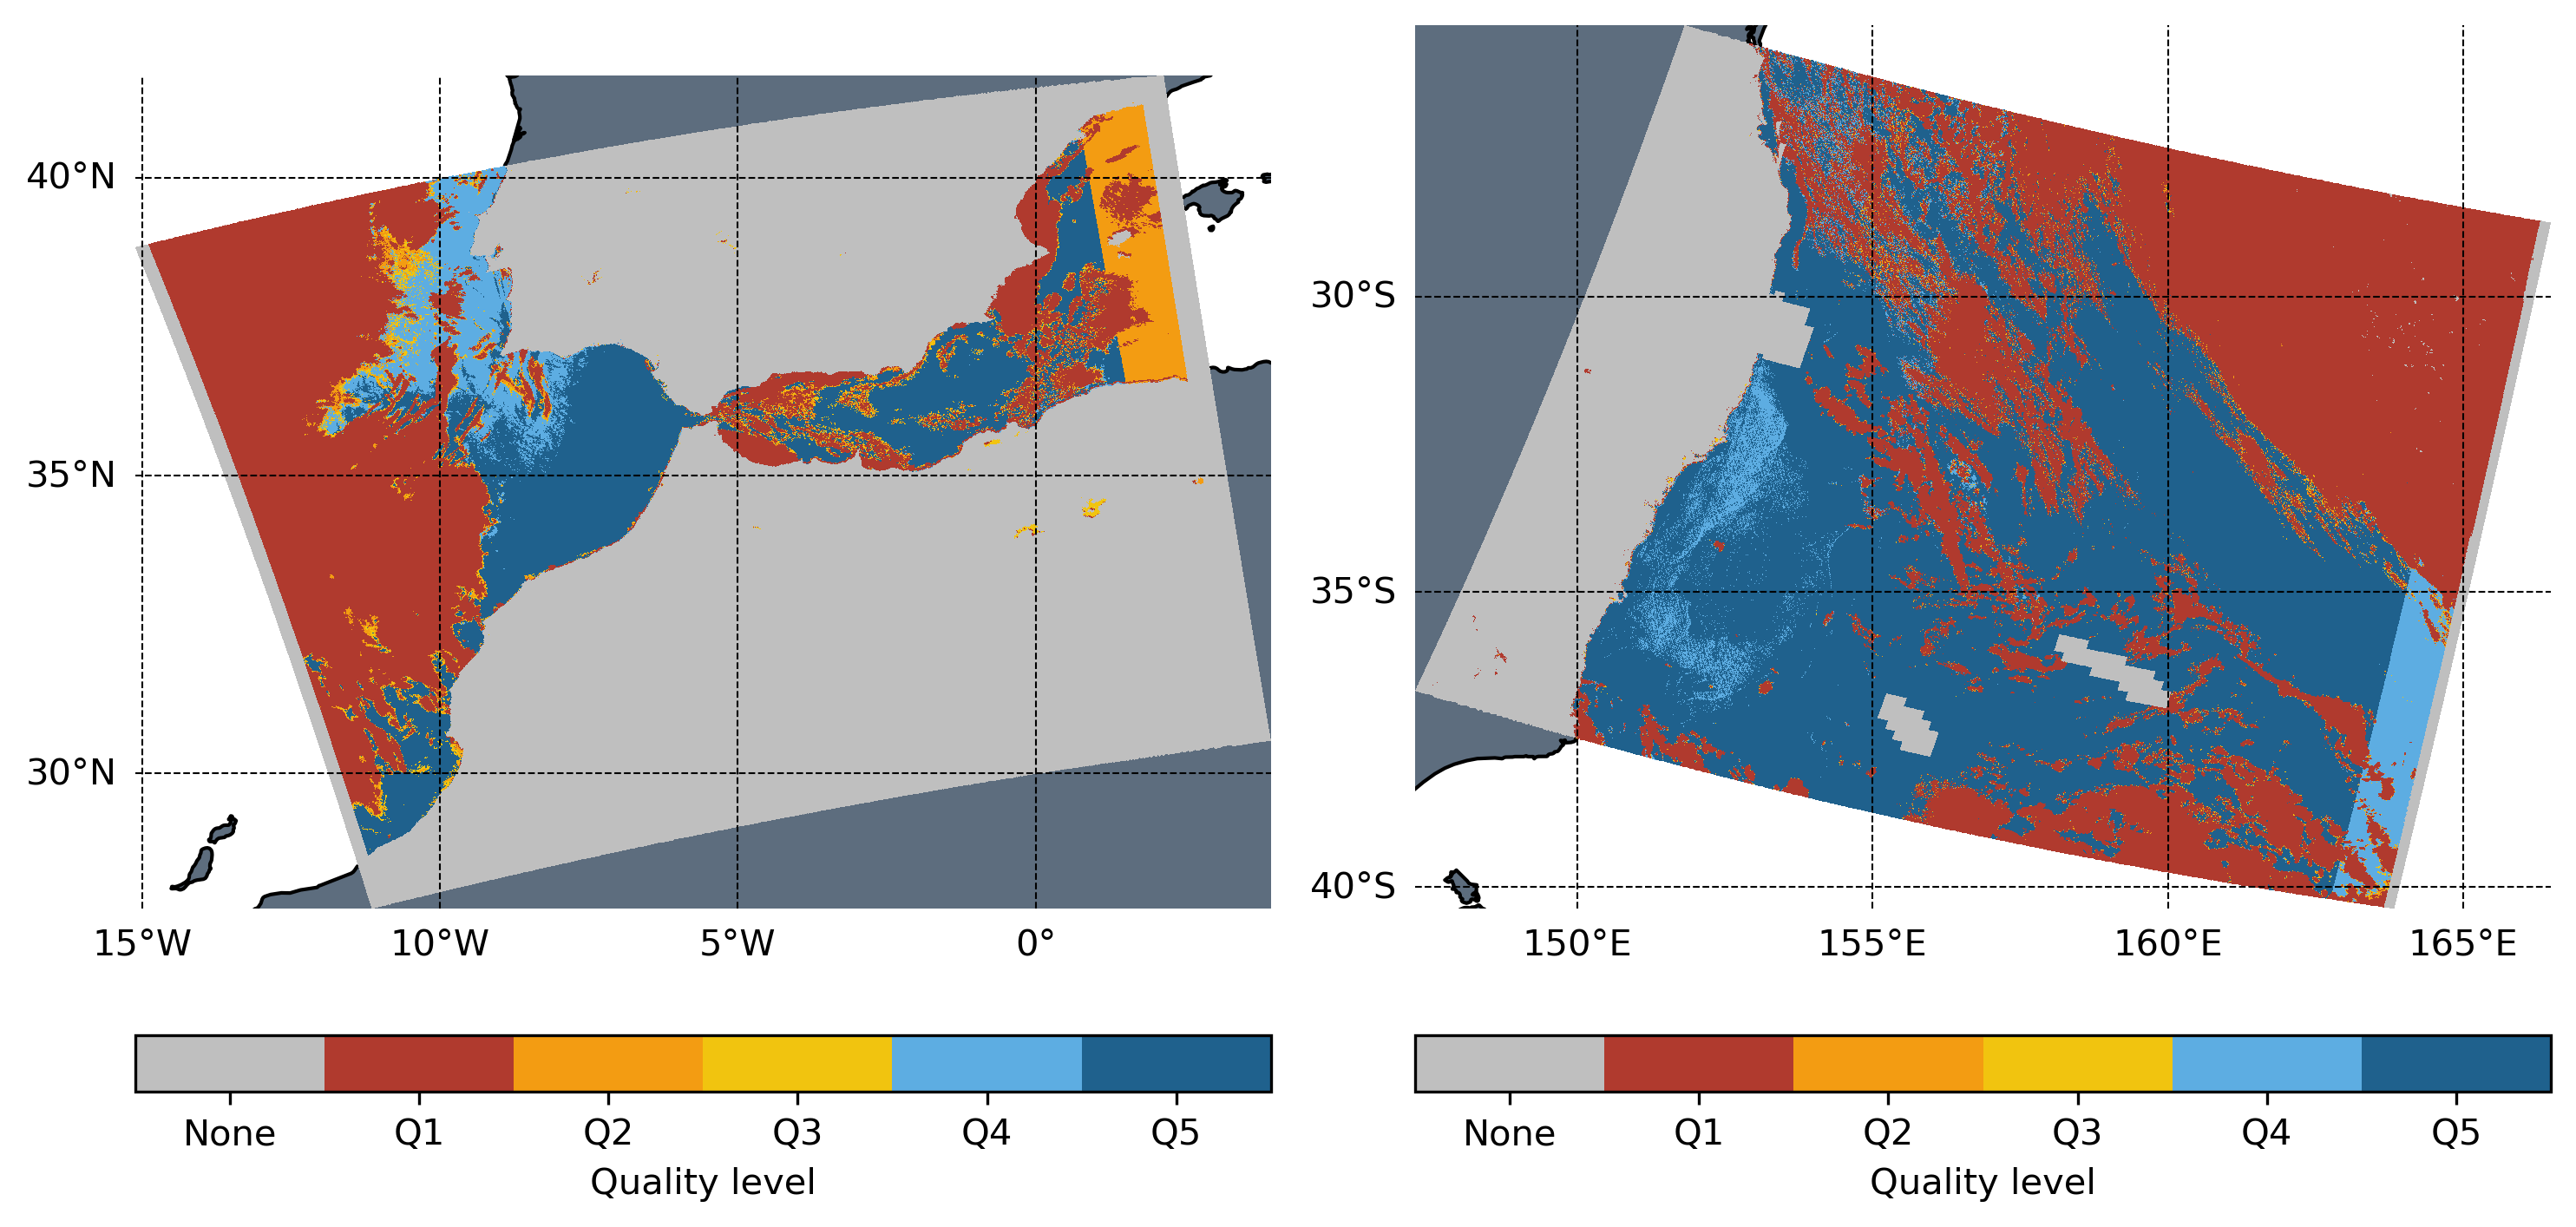

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10), dpi=300, subplot_kw={"projection": cartopy.crs.PlateCarree()})

for m, loc, vmin, vmax in zip(axs, coords , [0, 0], [6, 6]):
    print(f"Plotting {coords[loc]['name']}")

    # setting "x" to use full swath width
    minx = 0 ; maxx = np.shape(band_vars["lon"])[-1]
    miny = min(coords[loc]["y"]) ; maxy = max(coords[loc]["y"])

    pvar = band_vars["quality_level"][0, miny:maxy, minx:maxx]
    m.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='k', facecolor='#5D6D7E')
    p1 = slstr_plot(m, band_vars, pvar, [minx, maxx, miny, maxy, vmin, vmax], cmap=cmap)

    cbar = fig.colorbar(p1, ax=m, location='bottom', pad=0.05)
    cbar.set_label('Quality level')
    cbar.set_ticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
    cbar.set_ticklabels(['None','Q1','Q2','Q3','Q4','Q5'])
    
plt.tight_layout()

<div class="alert alert-info" role="alert">

## <a id='section7'></a>7. Bringing it all together
[Back to top](#TOC_TOP)

</div>

Our highest quality SST is:
* measured at night
* dual view
* bias corrected
* quality level 5

Lets apply all these (but also plot the day scene for interest)

Plotting Gulf of Cadiz
Plotting East Australian Current


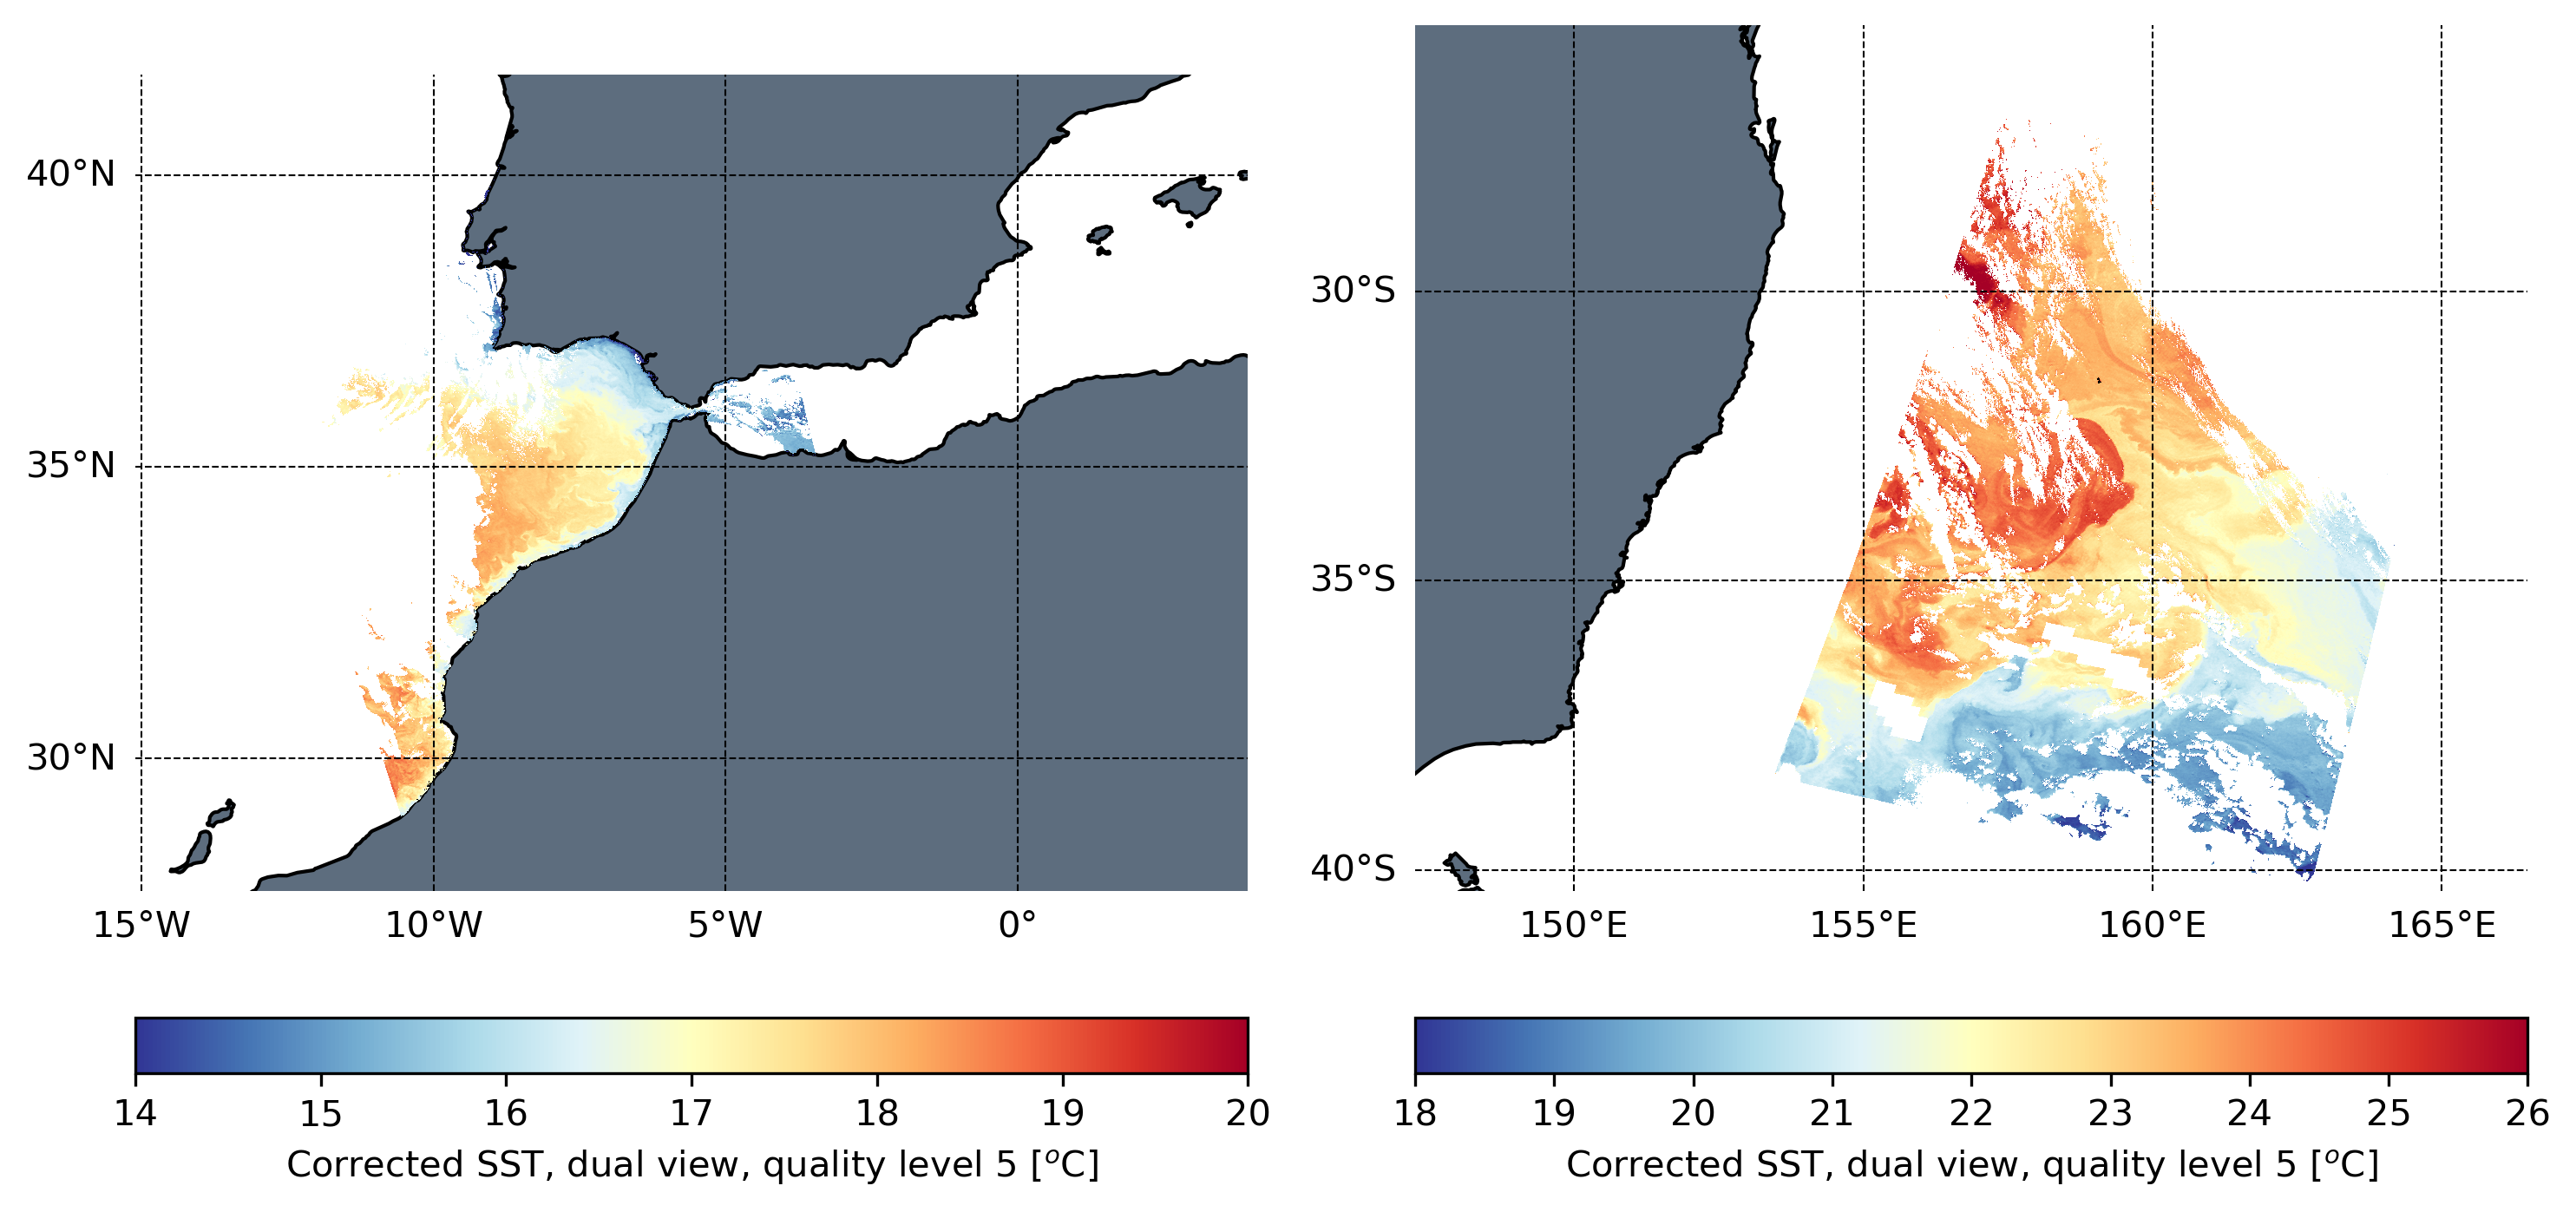

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10), dpi=300, subplot_kw={"projection": cartopy.crs.PlateCarree()})

for m, loc, vmin, vmax in zip(axs, coords, [14, 18], [20, 26]):
    print(f"Plotting {coords[loc]['name']}")

    # setting "x" to use full swath width
    minx = 0 ; maxx = np.shape(band_vars["lon"])[-1]
    miny = min(coords[loc]["y"]) ; maxy = max(coords[loc]["y"])

    SST = band_vars["sea_surface_temperature"][0, miny:maxy, minx:maxx]
    BIAS = band_vars["sses_bias"][0, miny:maxy, minx:maxx]
    ALGORITHM = band_vars["sst_algorithm_type"][0, miny:maxy, minx:maxx]
    QUAL = band_vars["quality_level"][0, miny:maxy, minx:maxx]
    
    remove_pixels = np.where((ALGORITHM < 4) | (QUAL < 5))
    FINAL_SST = np.array((SST + BIAS) - k_to_c)
    FINAL_SST[remove_pixels] = np.nan
    
    m.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='k', facecolor='#5D6D7E')
    p1 = slstr_plot(m, band_vars, FINAL_SST, [minx, maxx, miny, maxy, vmin, vmax], cmap=plt.cm.RdYlBu_r)

    cbar = fig.colorbar(p1, ax=m, location='bottom', pad=0.05)
    cbar.set_label('Corrected SST, dual view, quality level 5 [$^{o}$C]')
    
plt.tight_layout()

Costs us a lot of data, and in many cases we can relax both the algorithm type and, occasionally, the quality level

<hr>
<a href="../Index.ipynb"><< Index</a>
<br>
<a href="./1_5_SLSTR_radiance_BT_spectra.ipynb"><< SLSTR radiance and brightness temperature spectra</a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean/">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>